In [1]:
import sys
from pathlib import Path

# Add parent directory (case_studies/) to sys.path to discover restricted_boltzmann_machine
sys.path.append(str(Path.cwd().parent))

In [4]:
# Imports & paths
from pathlib import Path
import pickle
import numpy as np
import jax, jax.numpy as jnp
from jax.random import PRNGKey
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # for 3D bars

from rbm.rbm import RBM
from rbm.cosine_annealing_sampler import get_cosine_schedule

DATA_DIR   = Path("./data")
MODELS_DIR = Path("./models")
assert MODELS_DIR.exists(), "run the training notebook first!"

In [5]:
# Temperature schedule (cosine annealing)
T_sched = get_cosine_schedule(4.0, 0.4, 1000)

def load_params(ns):
    path = MODELS_DIR / f"rbm_w_vanilla_20_{ns}.pkl"
    with open(path, "rb") as f:
        return pickle.load(f)["params"]

# draw 20k samples from each model
rng = PRNGKey(123)
n_draw = 20_000
samples_dict = {}

for ns in (50, 1_000, 20_000):
    params = load_params(ns)
    rng, sk = jax.random.split(rng)
    rbm = RBM(n_visible=20, n_hidden=20, k=1)
    samp = rbm.generate(params=params,
                        n_samples=n_draw,
                        T_schedule=T_sched,
                        rng=sk)  # shape (n_draw,20)
    samples_dict[ns] = np.asarray(samp)
    print(f"✓ sampled {n_draw} for N_s={ns}")

✓ sampled 20000 for N_s=50
✓ sampled 20000 for N_s=1000
✓ sampled 20000 for N_s=20000


In [18]:
# looking at the relative frequencies for N_s = 50. simply print them

samp = samples_dict[50]
positions = samp.argmax(axis=1)  # 0...19
counts = np.bincount(positions, minlength=20)

rel = counts / n_draw
print(f"Relative frequencies for N_s=50:\n{rel}")

Relative frequencies for N_s=50:
[3.9035e-01 2.4630e-01 1.4125e-01 8.8650e-02 5.2200e-02 3.2400e-02
 2.0250e-02 1.0950e-02 5.8500e-03 4.9500e-03 2.1500e-03 1.3000e-03
 1.5500e-03 9.5000e-04 4.0000e-04 1.0000e-04 2.0000e-04 1.0000e-04
 1.0000e-04 0.0000e+00]


In [6]:
# For each sample, find the index of the single 'Z' spin
freqs = {}
for ns, samp in samples_dict.items():
    positions = samp.argmax(axis=1)  # 0...19
    counts = np.bincount(positions, minlength=20)
    rel = counts / n_draw
    freqs[ns] = rel
    print(f"N_s={ns}: mean rel. freq = {rel.mean():.3f}")

N_s=50: mean rel. freq = 0.050
N_s=1000: mean rel. freq = 0.050
N_s=20000: mean rel. freq = 0.050


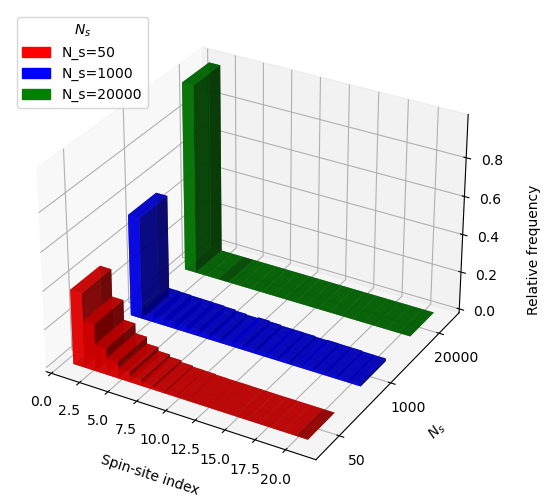

In [22]:
#### PLOT 3D HISTOGRAM (draw z‐label as external text)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
import numpy as np
from matplotlib.patches import Patch

# spin sites
xs = np.arange(1, 21)

# model categories equally spaced
Ns_list     = [50, 1000, 20000]
y_positions = np.arange(len(Ns_list))  # [0,1,2]
dy          = 0.5
dx          = 1.0

colors = {50:'red', 1000:'blue', 20000:'green'}

# create figure with extra right padding
fig = plt.figure(figsize=(8,6))
ax  = fig.add_subplot(111, projection='3d')

for i, ns in enumerate(Ns_list):
    zs     = freqs[ns]
    ys_pos = np.full_like(xs, y_positions[i])
    ax.bar3d(
        xs, ys_pos - dy/2, np.zeros_like(zs),
        dx, dy, zs,
        color=colors[ns], alpha=0.8
    )

# proxy legend
proxies = [Patch(color=colors[ns], label=f'N_s={ns}') for ns in Ns_list]
ax.legend(handles=proxies, title='$N_s$', loc='upper left')

# axis labels (no z-label here)
ax.set_xlabel('Spin‐site index', labelpad=10)
ax.set_ylabel('$N_s$',           labelpad=10)

# ticks
ax.set_yticks(y_positions)
ax.set_yticklabels(Ns_list)

# adjust margins manually, leave room at right
fig.subplots_adjust(left=0.10, right=0.75, bottom=0.10, top=0.90)

# draw z‐axis label outside the 3D axes
fig.text(
    0.78,      # x-position just to the right of axes area
    0.50,      # y-center
    'Relative frequency',
    rotation=90,
    va='center',
    ha='center'
)

plt.show()